In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a.zip" -d "/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training/a10761.png  
  inflating: /content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training/a10762.png  
  inflating: /content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training/a10763.png  
  inflating: /content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training/a10764.png  
  inflating: /content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training/a10765.png  
  inflating: /content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training/a10766.png  
  inflating: /content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training/a10767.png  
  inflating: /content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training/a10768.png  
  inf

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
from PIL import Image
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import natsort
from natsort import natsorted
import os

batch_size = 20
num_iters = 20000
input_dim = 28*28   # num_features = 784
num_hidden = 200 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path,main_dir):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.to_tensor = transforms.Compose([transforms.Resize(28),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5,), (0.5,))])

        self.data_info = pd.read_csv(csv_path, header=None)

        self.image_arr = np.asarray(self.data_info.iloc[:, 0])

        self.label_arr = np.asarray(self.data_info.iloc[:, 1])

        self.main_dir = main_dir
        all_imgs = os.listdir(main_dir)
        self.total_imgs=all_imgs


    def __getitem__(self, index):
    
            
        single_image_name = self.image_arr[index]
   
       
       # direc=('/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/')
        img_loc = os.path.join(self.main_dir, self.total_imgs[index])

        image = Image.open(img_loc).convert('L')
        tensor_image = self.to_tensor(image)
        faltu=[]
        single_image_name = self.image_arr[index]
        single_image_label = self.label_arr[index]
      
        return (tensor_image, single_image_label)

    def __len__(self):
        return len(self.total_imgs)


pathTrain='/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Training'
train_dataset = CustomDatasetFromImages('/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a-modified.csv',pathTrain)


pathTest='/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a/training-a/Testing'
test_dataset = CustomDatasetFromImages('/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/training-a-modified.csv',pathTest)
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


class DeepNeuralNetworkModel(nn.Module):
    
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(num_hidden, num_classes)   
    
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)

        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

model = DeepNeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
#criterion =nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 1*28*28).to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
       
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in (test_loader):
               
                images = images.view(-1, 28*28).to(device)
               
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)
    
                # Total correct predictions
                if torch.cuda.is_available():
                
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3048224449157715. Accuracy: 9.591474245115453
Iteration: 1000. Loss: 2.2981066703796387. Accuracy: 9.616848515605176
Iteration: 1500. Loss: 2.304640293121338. Accuracy: 9.71834559756407
Iteration: 2000. Loss: 2.3061673641204834. Accuracy: 10.149708195889367
Iteration: 2500. Loss: 2.3051562309265137. Accuracy: 9.769094138543517
Iteration: 3000. Loss: 2.305636167526245. Accuracy: 9.769094138543517
Iteration: 3500. Loss: 2.3030872344970703. Accuracy: 10.53032225323522
Iteration: 4000. Loss: 2.3012843132019043. Accuracy: 9.6422227860949
Iteration: 4500. Loss: 2.3002514839172363. Accuracy: 9.6422227860949
Iteration: 5000. Loss: 2.296499729156494. Accuracy: 10.149708195889367
Iteration: 5500. Loss: 2.3004801273345947. Accuracy: 9.71834559756407
Iteration: 6000. Loss: 2.303298234939575. Accuracy: 9.6422227860949
Iteration: 6500. Loss: 2.3012874126434326. Accuracy: 9.769094138543517
Iteration: 7000. Loss: 2.3019187450408936. Accuracy: 9.819842679522964
Iteration: 7500. 

[2.3048224449157715, 2.2981066703796387, 2.304640293121338, 2.3061673641204834, 2.3051562309265137, 2.305636167526245, 2.3030872344970703, 2.3012843132019043, 2.3002514839172363, 2.296499729156494, 2.3004801273345947, 2.303298234939575, 2.3012874126434326, 2.3019187450408936, 2.310906171798706, 2.295966863632202, 2.2853050231933594, 2.2828660011291504, 2.2852659225463867, 2.2654247283935547, 2.240252733230591, 2.1978824138641357, 2.138765811920166, 2.02994966506958, 2.1872174739837646, 2.032139301300049, 2.1831138134002686, 2.0003232955932617, 2.0426838397979736, 2.460265636444092, 1.9627139568328857, 2.0649666786193848, 2.2732701301574707, 2.1039481163024902, 1.9430068731307983, 2.3533029556274414, 1.9567711353302002, 2.023242712020874, 1.8340826034545898]


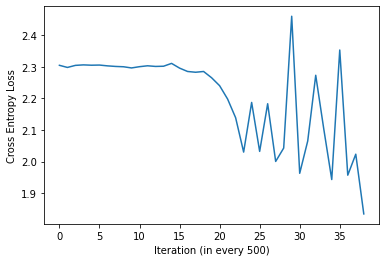

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.savefig("/content/drive/MyDrive/Soft Computing/Assignment 2/Dataset A/lossvsiteration.png")
plt.show()


In [ ]:
root_path = '/content/drive/MyDrive/Soft Computing/Assignment 2'
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'Assignment2_Exp1.pkl') 

load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Assignment2_Exp1.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded
